In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

キノコの観察その１では特徴の観察、選択を行なって終わった。        
新しく作ったCSVファイルで食用か、毒キノコかの判定を行うモデルを作ってみる。

In [2]:
# CSVファイル読み込み
df = pd.read_csv('new_mushrooms.csv')
df.head(5)

,Unnamed: 0,class,bruises,odor,stalk-surface-below-ring,ring-type,spore-print-color,population
0,0,1,1,6,2,4,2,3
1,1,0,1,0,2,4,3,2
2,2,0,1,3,2,4,3,2
3,3,1,1,6,2,4,2,3
4,4,0,0,5,2,0,3,0


In [3]:
# Unnamed が邪魔なので削除する
drop_columns = ['Unnamed: 0']
df = df.drop(drop_columns, axis=1)

In [4]:
# データを訓練データ、テストデータに分割する
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2)
# indexをリセットする
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(len(train_df),len(test_df))

6499 1625


In [5]:
# 特徴として使うデータとラベルとして使うデータに分ける
X_train = np.array(train_df.drop('class', axis=1).values).astype(np.float32)
y_train = np.array(train_df['class'].values).astype(np.float32)

X_test = np.array(test_df.drop('class', axis=1).values).astype(np.float32)
y_test = np.array(test_df['class'].values).astype(np.float32)

In [6]:
X_train[0]

array([ 1.,  3.,  2.,  4.,  2.,  2.], dtype=float32)

In [7]:
y_train = y_train.reshape(-1,1)
y_test =y_test.reshape(-1,1)

最初に、Tensorflowを使ったNNのロジスティック回帰モデルを作ってみる。

In [8]:
# 入力層
X = tf.placeholder(tf.float32, shape=[None, 6], name="input")
t = tf.placeholder(tf.float32, shape=[None, 1])
# パラメータ1
stddev = np.sqrt(2.0 / 6)
#W1 = tf.Variable(tf.truncated_normal([2,1], stddev=stddev))
W1 = tf.Variable(tf.truncated_normal([6,8]))
b1 = tf.Variable(tf.constant(0.1, shape=[1]))

# パラメータ2
#keep_prob = tf.placeholder(tf.float32,name="keep_prob") # ドロップアウトする割合
stddev = np.sqrt(2.0 / 8)
W2 = tf.Variable(tf.truncated_normal([8,1], stddev=stddev))
b2 = tf.Variable(tf.constant(0.1, shape=[1]))

# パラメータ3
#stddev = np.sqrt(2.0 / 24)
#W3 = tf.Variable(tf.truncated_normal([24,1], stddev=stddev))
#b3 = tf.Variable(tf.constant(0.1, shape=[1]))

layer1 = tf.matmul(X,W1) + b1
layer2 = tf.matmul(layer1,W2) + b2
#layer2_drop = tf.nn.dropout(layer2, keep_prob)
#layer3 = tf.matmul(layer2_drop,W3) + b3

p = tf.nn.sigmoid(layer2,name="output")
# 損失関数
loss = tf.reduce_mean(tf.square(p - t))
# 学習アルゴリズム
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)
# 精度
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 30
for i in range(10000):
    batch_mask = np.random.choice(X_train.shape[0], batch_size)
    x_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    sess.run(train_step,feed_dict={X: x_batch, t: y_batch})
    if i % 1000 == 0:
        train_acc, train_loss = sess.run([accuracy,loss], feed_dict={X: X_train, t: y_train})
        test_acc, test_loss = sess.run([accuracy,loss], feed_dict={X: X_test, t: y_test})
        print("[Train] step: %d, loss: %f, acc: %f, [Test] loss: %f, acc : %f" % (i, train_loss, train_acc,test_loss,test_acc))

[Train] step: 0, loss: 0.507670, acc: 0.466379, [Test] loss: 0.520131, acc : 0.456000
[Train] step: 1000, loss: 0.128580, acc: 0.859055, [Test] loss: 0.130518, acc : 0.862154
[Train] step: 2000, loss: 0.125802, acc: 0.862594, [Test] loss: 0.127334, acc : 0.862769
[Train] step: 3000, loss: 0.125300, acc: 0.864595, [Test] loss: 0.126921, acc : 0.864615
[Train] step: 4000, loss: 0.124192, acc: 0.865518, [Test] loss: 0.125900, acc : 0.865846
[Train] step: 5000, loss: 0.123875, acc: 0.865518, [Test] loss: 0.125953, acc : 0.865846
[Train] step: 6000, loss: 0.123877, acc: 0.865518, [Test] loss: 0.126027, acc : 0.865846
[Train] step: 7000, loss: 0.124318, acc: 0.854285, [Test] loss: 0.126636, acc : 0.856615
[Train] step: 8000, loss: 0.124152, acc: 0.877366, [Test] loss: 0.126926, acc : 0.872615
[Train] step: 9000, loss: 0.123503, acc: 0.874134, [Test] loss: 0.125999, acc : 0.870769


90%の精度は難しそうだ。       
線形分類器の次はツリー帰納法、決定木で試してみる。

In [10]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

model = clf.fit(X_train, y_train)

In [11]:
tree_pred = clf.predict(X_test)

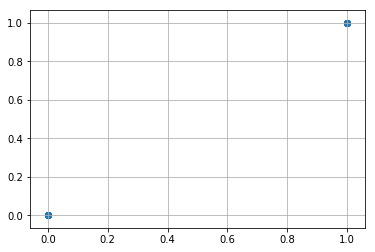

In [12]:
plt.grid()
plt.scatter(y_test, tree_pred)
plt.show()

最後に噂のxgboostでも試してみる

In [13]:
from xgboost import XGBRegressor
clf2 = XGBRegressor()

model2 = clf2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
xg_pred = clf2.predict(X_test)

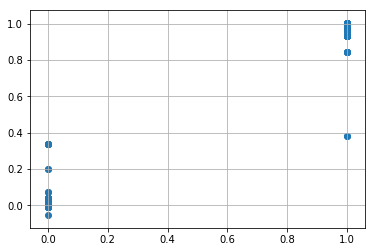

In [15]:
plt.grid()
plt.scatter(y_test, xg_pred)
plt.show()

各モデルのテストデータに対する損失(二乗誤差)を比べる。

In [16]:
nn_pred = sess.run(p,feed_dict={X:X_test}).reshape(-1,)
print('NN LogisticRegression mean square loss = {}'.format(np.mean(np.square(y_test - nn_pred))))
print('DecisionTree mean square loss = {}'.format(np.mean(np.square(y_test - tree_pred))))
print('XGBoost mean square loss = {}'.format(np.mean(np.square(y_test - xg_pred))))

NN LogisticRegression mean square loss = 0.42187488079071045
DecisionTree mean square loss = 0.49829112426035505
XGBoost mean square loss = 0.49298372864723206


決定木の判別をどう行なっているかグラフで確認する

In [17]:
from sklearn import tree

with open('mushrooms_tree.dot', mode='w') as f:
    tree.export_graphviz(clf, out_file=f)